In [ ]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
import pandas as pd
from tqdm import tqdm
import numpy as np

In [ ]:
# Import tensorflow dataset
ds = tfds.load(name='gigaword')

Shuffling and writing examples to /root/tensorflow_datasets/gigaword/1.2.0.incomplete1UXPV6/gigaword-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/gigaword/1.2.0.incomplete1UXPV6/gigaword-validation.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/gigaword/1.2.0.incomplete1UXPV6/gigaword-test.tfrecord
Dataset gigaword downloaded and prepared to /root/tensorflow_datasets/gigaword/1.2.0. Subsequent calls will reuse this data.


In [ ]:
# Convert tensorflow dataset to pairs

train_size = 300000
valid_size = 10000
test_size = -1

def example_pair(example):
    src = example['document'].decode('utf-8')
    trg = example['summary'].decode('utf-8')
    return [src, trg]

def tfds_pairs(ds, size):
    pairs = []
    ds = tfds.as_numpy(ds)
    tbar = tqdm(ds)
    for example in tbar:
        pairs.append(example_pair(example))
        if len(pairs) == size: 
            tbar.close()
            break
    return pairs

train_pairs = tfds_pairs(ds['train'], train_size)
valid_pairs = tfds_pairs(ds['validation'], valid_size)
test_pairs = tfds_pairs(ds['test'], test_size)

print('Number of train examples: {}'.format(len(train_pairs)))
print('Number of valid examples: {}'.format(len(valid_pairs)))
print('Number of test examples: {}'.format(len(test_pairs)))

299876it [01:17, 3889.18it/s]
9686it [00:02, 3727.97it/s]
1951it [00:00, 3785.02it/s]

Number of train examples: 300000
Number of valid examples: 10000
Number of test examples: 1951


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


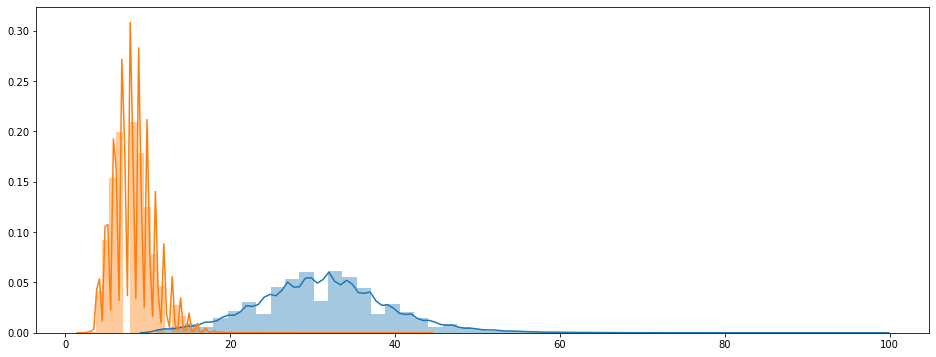

In [ ]:
# Show lengths distribution of train data
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16, 6))

src_len = []
trg_len = []
for pair in train_pairs:
    src_len.append(len(pair[0].split()))
    trg_len.append(len(pair[1].split()))

sns.distplot(src_len)
sns.distplot(trg_len)

In [ ]:
# Preprocess data
# 1. Text cleaning
# 2. Filter outliers
import re

# Set limits of the lengths
max_src_len = 45
min_src_len = 18
max_trg_len = 13
min_trg_len = 5

def clean_sent(sent):
    sent = sent.lower()
    sent = re.sub(r'-.*-', ' ', sent) # Removes word inside - -
    sent = re.sub(r'#.*#', '##', sent) # Removes word inside # #
    # Handle numbers in sent
    sent = re.sub(r'([a-z0-9.,<>])(#)', r'\1 \2', sent)
    sent = re.sub(r'(#)([a-z0-9.,<>])', r'\1 \2', sent)
    sent = re.sub(r'#{1,}', r'#', sent)
    sent = sent.replace('#', '<NUM>')
    # Remove special symbols
    sent = re.sub(r'[^a-zA-Z.,/-<>#\']', ' ', sent) 
    sent = sent.replace('/', ' ')
    sent = sent.replace(';', ' ')
    sent = sent.replace('<num>', ' <NUM> ')
    sent = sent.split()
    sent = [word for word in sent if len(word) > 1 or word in ['i', 'a']]
    sent = ' '.join(sent)
    return sent

def clean_pair(pair):
    src = clean_sent(pair[0])
    trg = clean_sent(pair[1])
    return [src, trg]

def clean_pairs(pairs):
    return [clean_pair(pair) for pair in pairs]

def filter_pairs(pairs):
    filtered = []
    for pair in pairs:
        src, trg = pair
        src_len = len(src.split())
        trg_len = len(trg.split())
        if 'unk' not in pair[0] and 'unk' not in pair[1]: # Remove default unk
            if min_src_len <= src_len <= max_src_len and min_trg_len <= trg_len <= max_trg_len: # Remove outliers
                filtered.append(pair)
    return filtered

train_pairs = filter_pairs(clean_pairs(train_pairs))
valid_pairs = filter_pairs(clean_pairs(valid_pairs))
test_pairs = filter_pairs(clean_pairs(test_pairs))

print('Number of train examples: {}'.format(len(train_pairs)))
print('Number of valid examples: {}'.format(len(valid_pairs)))
print('Number of test examples: {}'.format(len(test_pairs)))


Number of train examples: 208647
Number of valid examples: 6644
Number of test examples: 909


In [ ]:
import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Custom vocab object
class Vocab():
   
    def __init__(self):
        self.PAD = 0
        self.SOS = 1
        self.EOS = 2
        self.UNK = 3
        self.NUM = 4
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>", 4: "<NUM>"}
        self.n_words = 5

    def add_sent(self, sentence):
        for word in sentence.split():
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def __getitem__(self, item):
        if type(item) == str:
            return int(self.word2index.get(item, self.UNK)) # Return the index of <UNK> if input word is not in the vocab
        elif type(item) == int:
            return self.index2word[item]

In [ ]:
# Build vocab from train data

def build_vocab(pairs):
    vocab = Vocab()
    print("Read {} example pairs".format(len(pairs)))
    for pair in pairs:
        vocab.add_sent(pair[0])
        vocab.add_sent(pair[1])
    print('Number of vocab: {}'.format(vocab.n_words))
    
    return vocab

vocab = build_vocab(train_pairs)

Read 208647 example pairs
Number of vocab: 64514


In [ ]:
def batchify(pairs, batch_size):
    # Convert a dataset into a list of batches
    # Sort all example pairs in descending order: src_len
    pairs = sorted(pairs, key=lambda p: len(p[0].split()), reverse=True)
    pairs = [pairs[i:i+batch_size] for i in range(0, len(pairs), batch_size)]
    return pairs

def encode_sent(sent):
    return [vocab.SOS] + [vocab[word] for word in sent.split()] + [vocab.EOS]

def encode_pair(pair):
    src = encode_sent(pair[0])
    trg = encode_sent(pair[1])
    return src, trg

def encode_batch(batch):
    return [encode_pair(pair) for pair in batch]

def pad_sent(sent, max_len):
    # Post-padding
    sent += [vocab.PAD]*(max_len - len(sent))
    return sent

def pad_mask(tensor):
    # tensor [batch_size, sent_len]
    mask = (tensor != vocab.PAD).unsqueeze(1).unsqueeze(2) # [batch size, 1, 1, sent_len]
    return mask
    
def sub_mask(tensor):
    # tensor [batch_size, sent_len]
    sent_len = tensor.size(1)
    mask = torch.tril(torch.ones((sent_len, sent_len), device=device)).bool() # [trg len, trg len]
    return mask

def tensor_batch(batch):
    # Encode batch
    batch = encode_batch(batch)
    
    src = [pair[0] for pair in batch]
    trg = [pair[1] for pair in batch]
    src_len = [len(sent) for sent in src]
    trg_len = [len(sent) for sent in trg]
    
    # Padding
    src = [pad_sent(sent, max(src_len)) for sent in src]
    trg = [pad_sent(sent, max(trg_len)) for sent in trg]
    
    # Convert to tensor
    src =  torch.tensor(src, dtype=torch.long).to(device) # [batch_size, src_len]
    trg =  torch.tensor(trg, dtype=torch.long).to(device) # [batch_size, trg_len]

    # Create mask
    trg_no_eos = trg[:, :-1] # trg without <EOS> [batch_size, trg len-1]
    trg_no_sos = trg[:, 1:] # trg without <SOS> [batch_size, trg len-1]
    trg_mask = pad_mask(trg_no_eos) & sub_mask(trg_no_eos) # [batch_size, 1, trg_len, trg_len]
    src_mask = pad_mask(src) # [batch_size, 1, 1, src_len]

    return [[src, trg], 
            [trg_no_sos, trg_no_eos], 
            [src_mask, trg_mask]]

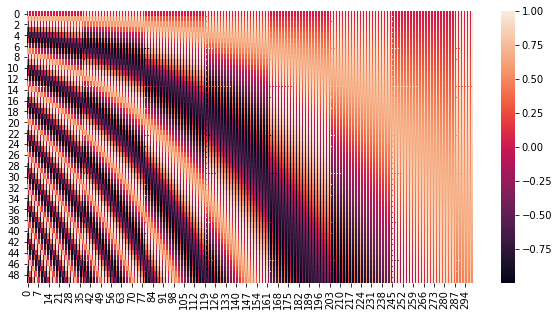

In [ ]:
import seaborn as sns

class Word_Embedding(nn.Module):
    def __init__(self, vocab_dim, model_dim):
        super(Word_Embedding, self).__init__()
        self.embedding = nn.Embedding(vocab_dim, model_dim)
    def forward(self, tensor):
        embedded = self.embedding(tensor) # [batch_size, src_len, model_dim]
        model_dim = embedded.size(-1)
        scale = torch.sqrt(torch.tensor(model_dim, dtype=torch.float, device=device))
        embedded = embedded * scale # [batch_size, src_len, model_dim]
        return embedded

def positional_encoding_matrix(max_len, model_dim):
    pe = torch.zeros(max_len, model_dim).to(device)
    pos = torch.arange(0, max_len)
    pos = pos.unsqueeze(1)
    angle = pos * torch.exp(torch.arange(0, model_dim, 2) * -(np.log(max_len) / model_dim))
    pe[:, 0::2] = torch.sin(angle)
    pe[:, 1::2] = torch.cos(angle)
    return pe

plt.figure(figsize=(10, 5))
pe = positional_encoding_matrix(50, 300)
sns.heatmap(pe.cpu())

class Static_Positional_Encoding(nn.Module):
    def __init__(self, max_len, model_dim):
        super(Static_Positional_Encoding, self).__init__()
        pe = positional_encoding_matrix(max_len, model_dim)
        pe = pe.unsqueeze(0)
        self.pos_encode = pe

    def forward(self, tensor):
        # tensor [batch_size, sent_len]
        sent_len = tensor.size(1)
        tensor = self.pos_encode[:, :sent_len] # [1, sent_len, model_dim]
        return tensor

class Learn_Positional_Encoding(nn.Module):
    def __init__(self, max_len, model_dim):
        super(Learn_Positional_Encoding, self).__init__()
        self.pos_encode = nn.Embedding(max_len, model_dim)

    def forward(self, tensor):
        # tensor [batch_size, sent_len]
        tensor = self.pos_encode(tensor) # [1, sent_len, model_dim]
        return tensor


In [ ]:
def scaled_dp_attention(Q, K, V, mask):
    # Q [batch_size, n_heads, query_len, head_dim]
    # K [batch_size, n_heads, key_len, head_dim]
    # V [batch_size, n_heads, value_len, head_dim]
    head_dim = K.size(-1)
    K_T = K.permute(0, 1, 3, 2) # [batch_size, n_heads, head_dim, key_len]
    scale = torch.sqrt(torch.tensor(head_dim, dtype=torch.float, device=device)) # [1]
    attention = torch.matmul(Q, K_T)/scale # [batch_size, n_heads, query_len, key_len]
    attention = attention.masked_fill(mask==0, -1e9)
    attention = torch.softmax(attention, dim=-1) # [batch size, n heads, query_len, key_len]
    attention = torch.matmul(attention, V) # [batch size, n heads, query_len, head_dim]
    attention = attention.permute(0, 2, 1, 3) # [batch size, query len, n_heads, head_dim]
    return attention

class Multi_Head_Attention(nn.Module):
    def __init__(self, model_dim, n_heads):
        super(Multi_Head_Attention, self).__init__()
        assert model_dim % n_heads == 0
        self.model_dim = model_dim
        self.n_heads = n_heads
        self.head_dim = model_dim // n_heads
        self.ff_q = nn.Linear(model_dim, model_dim, bias=False)
        self.ff_k = nn.Linear(model_dim, model_dim, bias=False)
        self.ff_v = nn.Linear(model_dim, model_dim, bias=False)
        self.ff_o = nn.Linear(model_dim, model_dim, bias=False)
        
    def forward(self, query, key, value, mask):
        # query = [batch size, query len, model_dim]
        # key = [batch size, key len, model_dim]
        # value = [batch size, value len, model_dim]      
        batch_size = query.size(0)
        Q = self.ff_q(query).view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3) # [batch size, n heads, query len, head dim]
        K = self.ff_k(key).view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3) # [batch size, n heads, key len, head dim]
        V = self.ff_v(value).view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3) # [batch size, n heads, value len, head dim]
        attention = scaled_dp_attention(Q, K, V, mask)
        attention = attention.contiguous() # [batch size, query len, n heads, head dim]
        attention = attention.view(batch_size, -1, self.model_dim) # [batch size, query len, model_dim]
        x = self.ff_o(attention) # [batch size, query len, model_dim]
        return x

class Positionwise_FF(nn.Module):
    def __init__(self, model_dim, ff_dim):
        super(Positionwise_FF, self).__init__()
        self.ff_1 = nn.Linear(model_dim, ff_dim, bias=True)
        self.ff_2 = nn.Linear(ff_dim, model_dim, bias=True)
        
    def forward(self, x):
        # x = [batch size, sent_len, model_dim]
        x = self.ff_2(torch.relu(self.ff_1(x))) # [batch size, sent_len, model_dim]
        return x

In [ ]:
class Encoder(nn.Module):
    def __init__(self, model_dim, n_layers, n_heads, ff_dim, dp):
        super(Encoder, self).__init__()
        self.encoder_layers = nn.ModuleList([Encoder_layer(model_dim, n_heads, ff_dim, dp) for _ in range(n_layers)])

    def forward(self, src, src_mask):
        # src [batch_size, src_len, model_dim]
        # src_mask [batch_size, src_len]
        for layer in self.encoder_layers:
            src = layer(src, src_mask) # [batch_size, src_len, model_dim]
        return src

class Encoder_layer(nn.Module):
    def __init__(self, model_dim, n_heads, ff_dim, dp):
        super(Encoder_layer, self).__init__()
        self.norm_1 = nn.LayerNorm(model_dim)
        self.norm_2 = nn.LayerNorm(model_dim)
        self.multi_head_attention = Multi_Head_Attention(model_dim, n_heads)
        self.positionwise_ff = Positionwise_FF(model_dim, ff_dim)
        self.dropout = nn.Dropout(dp)
        
    def forward(self, src, src_mask):
        # Sublayers:
        # Multi_Head_Attention
        # Add & Norm
        # Positionwise_FF
        # Add & Norm
        # src [batch_size, src_len, model_dim]
        # src_mask [batch_size, src_len]
        src = self.norm_1(src + self.dropout(self.multi_head_attention(src, src, src, src_mask))) # [batch_size, src_len, model_dim]
        src = self.norm_2(src + self.dropout(self.positionwise_ff(src))) # [batch_size, src_len, model_dim]
        return src

class Decoder(nn.Module):
    def __init__(self, vocab_dim, model_dim, n_layers, n_heads, ff_dim, dp):
        super(Decoder, self).__init__()

        self.decoder_layers = nn.ModuleList([Decoder_layer(model_dim, n_heads, ff_dim, dp) for _ in range(n_layers)])
        self.generator = nn.Linear(model_dim, vocab_dim, bias=False)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        # trg = [batch size, trg len]
        # enc_src = [batch size, src len, hid dim]
        # trg_mask = [batch size, trg len]
        # src_mask = [batch size, src len]     
        batch_size = trg.size(0)
        trg_len = trg.size(1)
        for layer in self.decoder_layers:
            trg = layer(trg, enc_src, trg_mask, src_mask) # [batch_size, trg_len, model_dim]
        output = self.generator(trg) # [batch_size, trg_len, vocab_dim]
        return output

class Decoder_layer(nn.Module):
    def __init__(self, model_dim, n_heads, ff_dim, dp):
        super(Decoder_layer, self).__init__()
        self.norm_1 = nn.LayerNorm(model_dim)
        self.norm_2 = nn.LayerNorm(model_dim)
        self.norm_3 = nn.LayerNorm(model_dim)
        self.multi_head_attention_1 = Multi_Head_Attention(model_dim, n_heads)
        self.multi_head_attention_2 = Multi_Head_Attention(model_dim, n_heads)
        self.positionwise_ff = Positionwise_FF(model_dim, ff_dim)
        self.dropout = nn.Dropout(dp)

    def forward(self, trg, output, trg_mask, src_mask):
        # Sublayers:
        # Multi_Head_Attention
        # Add & Norm
        # Multi_Head_Attention
        # Add & Norm
        # Positionwise_FF
        # Add & Norm
        # trg [batch_size, trg_len, model_dim]
        # output [batch_size, src_len, model_dim]
        trg = self.norm_1(trg + self.dropout(self.multi_head_attention_1(trg, trg, trg, trg_mask))) # [batch_size, src_len, model_dim]
        trg = self.norm_2(trg + self.dropout(self.multi_head_attention_2(trg, output, output, src_mask))) # [batch_size, src_len, model_dim]
        trg = self.norm_3(trg + self.dropout(self.positionwise_ff(trg))) # [batch_size, src_len, model_dim]
        return trg

In [ ]:
class Model(nn.Module):
    def __init__(self, vocab_dim, max_len, model_dim, n_layers, n_heads, ff_dim, dp):
        super(Model, self).__init__()
        self.embedding = Word_Embedding(vocab_dim, model_dim).to(device)
        self.static_pos_encoding = Static_Positional_Encoding(max_len, model_dim).to(device)
        self.learn_pos_encoding = Learn_Positional_Encoding(max_len, model_dim).to(device)
        self.encoder = Encoder(model_dim, n_layers, n_heads, ff_dim, dp).to(device)
        self.decoder = Decoder(vocab_dim, model_dim, n_layers, n_heads, ff_dim, dp).to(device)
        self.pos_encoding = self.static_pos_encoding
        self.dropout = nn.Dropout(dp)

    def forward(self, src, trg, src_mask, trg_mask):
        # src [batch size, src len]
        # trg [batch size, trg len] 
        # src_mask [batch size, 1, 1, src_len]
        # trg_mask [batch size, 1, trg_len, trg_len]
        src = self.embedding(src)
        trg = self.embedding(trg)

        src = self.dropout(src + self.pos_encoding(src))
        trg = self.dropout(trg + self.pos_encoding(trg))

        enc_src = self.encoder(src, 
                               src_mask) # [batch_size, src_len, model_dim]
        
        output = self.decoder(trg, 
                              enc_src, 
                              trg_mask, 
                              src_mask) # [batch_size, trg_len, vocab_dim]
        return output

In [ ]:
# Optimiser
# https://stackoverflow.com/questions/48324152/pytorch-how-to-change-the-learning-rate-of-an-optimizer-at-any-given-moment-no
class Transformer_Optimizer():
    def __init__(self, model_dim, warmup_steps, optimizer):
        self.model_dim = model_dim
        self.warmup_steps = warmup_steps
        self.optimizer = optimizer
        self.n_step = 0

    def step(self):
        self.n_step += 1
        lrate = (self.model_dim**(-0.5)) * np.min([self.n_step**(-0.5), self.n_step*(self.warmup_steps**(-1.5))])
        for group in self.optimizer.param_groups:
            group['lr'] = lrate
        self.optimizer.step()

# Labal smoothing
class Label_Smoothing(nn.Module):
    def __init__(self):
        super(Label_Smoothing, self).__init__()
    def forward(self, output, trg, alpha=0.1):
        logprobs = F.log_softmax(output, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=trg.unsqueeze(1)).squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = (1-alpha) * nll_loss + alpha * smooth_loss
        return loss.mean()

In [ ]:
def train(batches, model, optimizer, label_smoothing):

    epoch_loss = []

    for batch in batches:

        optimizer.optimizer.zero_grad()

        batch = tensor_batch(batch)
        src = batch[0][0]
        trg = batch[0][1]
        trg_no_sos = batch[1][0]
        trg_no_eos = batch[1][1]
        src_mask = batch[2][0]
        trg_mask = batch[2][1]

        output = model(src, trg_no_eos, src_mask, trg_mask) # [batch_size, trg_len-1, vocab_dim]

        output_dim = output.size(-1)
        output = output.contiguous().view(-1, output_dim) # [batch_size*trg_len-1, vocab_dim]
        trg_no_sos = trg_no_sos.contiguous().view(-1) # [batch_size*trg_len-1]

        loss = label_smoothing(output, trg_no_sos)

        loss.backward()
        optimizer.step()

        loss = loss.item()
        if len(epoch_loss) % 200 == 0:
            print("batch: {}\t train loss: {:.4f}".format(len(epoch_loss), loss))
        epoch_loss.append(loss)
       
    return epoch_loss

def eval(batches, model, criterion):
    
    epoch_loss = []
    with torch.no_grad():

        for batch in batches:

            batch = tensor_batch(batch)
            src = batch[0][0]
            trg = batch[0][1]
            trg_no_sos = batch[1][0]
            trg_no_eos = batch[1][1]
            src_mask = batch[2][0]
            trg_mask = batch[2][1]

            output = model(src, trg_no_eos, src_mask, trg_mask) # [batch_size, trg_len-1, vocab_dim]

            output_dim = output.size(-1)
            output = output.contiguous().view(-1, output_dim) # [batch_size*trg_len-1, vocab_dim]
            trg_no_sos = trg_no_sos.contiguous().view(-1) # [batch_size*trg_len-1]

            loss = criterion(output, trg_no_sos)

            loss = loss.item()
            epoch_loss.append(loss)

    return epoch_loss

In [ ]:
model_dim = 300
max_len = 50
vocab_dim = vocab.n_words
n_epochs = 15
n_layers = 3
n_heads = 10
ff_dim = 600
dp = 0.1
batch_size = 128
warmup_steps = 4000


train_batches = batchify(train_pairs, batch_size)
valid_batches = batchify(valid_pairs, batch_size)

model = Model(vocab_dim, max_len, model_dim, n_layers, n_heads, ff_dim, dp)
adam_optimizer = torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
optimizer = Transformer_Optimizer(model_dim, warmup_steps, optimizer=adam_optimizer)
criterion = nn.CrossEntropyLoss(ignore_index=vocab.PAD)
label_smoothing = Label_Smoothing()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Embedding has {count_parameters(model.embedding):,} trainable parameters')
print(f'Positional Encoding has {count_parameters(model.pos_encoding):,} trainable parameters')
print(f'Encoder has {count_parameters(model.encoder):,} trainable parameters')
print(f'Decoder has {count_parameters(model.decoder):,} trainable parameters')

Embedding has 19,354,200 trainable parameters
Positional Encoding has 0 trainable parameters
Encoder has 2,166,300 trainable parameters
Decoder has 22,602,300 trainable parameters


In [ ]:
best_valid_loss = float('inf')
train_losses = []
valid_losses = []

for epoch in range(1, n_epochs+1):
    
    train_loss = train(iter(train_batches), model, optimizer, criterion)
    valid_loss = eval(iter(valid_batches), model, criterion)
    print('epoch: {}\t epoch train loss: {:.4f}\t epoch valid loss: {:.4f}'.format(epoch, np.mean(train_loss), np.mean(valid_loss)))

    train_losses += train_loss
    valid_losses += valid_loss

    if np.mean(valid_loss) < best_valid_loss:
        best_valid_loss = np.mean(valid_loss)
        torch.save(model.state_dict(), 'transformer.w')

batch: 0	 train loss: 11.2191
batch: 200	 train loss: 8.8169
batch: 400	 train loss: 7.3881
batch: 600	 train loss: 7.1917
batch: 800	 train loss: 7.0321
batch: 1000	 train loss: 6.8176
batch: 1200	 train loss: 6.5757
batch: 1400	 train loss: 6.1884
batch: 1600	 train loss: 5.9943
epoch: 1	 epoch train loss: 7.3194	 epoch valid loss: 6.2566
batch: 0	 train loss: 6.5997
batch: 200	 train loss: 6.2853
batch: 400	 train loss: 5.9132
batch: 600	 train loss: 5.9249
batch: 800	 train loss: 5.7904
batch: 1000	 train loss: 5.6215
batch: 1200	 train loss: 5.4731
batch: 1400	 train loss: 5.1580
batch: 1600	 train loss: 5.1526
epoch: 2	 epoch train loss: 5.7013	 epoch valid loss: 5.5003
batch: 0	 train loss: 5.8783
batch: 200	 train loss: 5.6615
batch: 400	 train loss: 5.2271
batch: 600	 train loss: 5.3315
batch: 800	 train loss: 5.3001
batch: 1000	 train loss: 5.0884
batch: 1200	 train loss: 4.9620
batch: 1400	 train loss: 4.7023
batch: 1600	 train loss: 4.7377
epoch: 3	 epoch train loss: 5.1437

KeyboardInterrupt: ignored

In [ ]:
def inference(src, model):

   
    with torch.no_grad():
        
        src = encode_sent(src)
        src = torch.tensor(src, dtype=torch.long, device=device).unsqueeze(0) # [1, src_len]
        src_len = src.size(1) 
        src_mask = pad_mask(src) # [batch size, 1, 1, src_len]
        src = model.embedding(src)
        ## Encoder
        enc_src = model.encoder(src + model.pos_encoding(src), 
                                src_mask) # [1, src_len, model_dim]

        ## Decoder
        pred_trgs = [vocab.SOS]

        for t in range(src_len):

            trg = torch.tensor(pred_trgs, dtype=torch.long, device=device).unsqueeze(0) # [1, t+1]
            trg_mask = pad_mask(trg) & sub_mask(trg) # [batch size, 1, t+1, t+1]  
            trg = model.embedding(trg)
            output = model.decoder(trg + model.pos_encoding(trg), 
                                   enc_src, 
                                   trg_mask, 
                                   src_mask)
        
            pred_trg = output.argmax(2)[:, -1]
        
            pred_trgs.append(pred_trg.item())

            if pred_trgs[-1] == vocab.EOS:
                break
    
        pred_trgs = [vocab[idx] for idx in pred_trgs][1:]

        pred_trgs = ' '.join(pred_trgs)
    
        return pred_trgs

In [ ]:
def inference_randomly(pairs, model, n=100):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_sent = inference(pair[0], model)
        print('>', output_sent)
        print('')

model.load_state_dict(torch.load('transformer.w'))
inference_randomly(test_pairs, model, n=20)

In [ ]:
def output_csv(pairs, model):
    srcs = []
    reference = []
    candidate = []
    for pair in pairs:
        src = pair[0]
        trg = pair[1]
        pred_trg = inference(src, model)
        pred_trg = ' '.join(pred_trg.split()[:-1]) # Trim <EOS> from the sentence
        srcs.append(src)
        reference.append(trg)
        candidate.append(pred_trg)
    df = pd.DataFrame({'src': srcs,
                       'reference': reference,
                       'candidate': candidate})
    df.to_csv(path_or_buf='transformer.csv', 
              index=False)
    
model.load_state_dict(torch.load('transformer.w'))
output_csv(test_pairs, model)
